<a href="https://colab.research.google.com/github/Angad99/Chest-X-Ray-Disease-Detection/blob/master/Preprocessing_and_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing and Modeling

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Chest-X-Ray-Disease-Detection/

/content/drive/MyDrive/Chest-X-Ray-Disease-Detection


In [3]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import random

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SIZE = 256

In [5]:
FILENAMES = tf.io.gfile.glob("data/*.tfrec")

print("Train TFRecord Files:", len(FILENAMES))

Train TFRecord Files: 256


In [6]:
#https://keras.io/examples/keras_recipes/tfrecord/

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    #image = tf.image.resize(image, (256,256))
    image = tf.cast(image, tf.float32)/255.0
    image = tf.reshape(image, [768,768,1])
    return image

In [7]:
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_id': tf.io.FixedLenFeature([], tf.string),
    'No Finding': tf.io.FixedLenFeature([], tf.int64),
    'Atelectasis': tf.io.FixedLenFeature([], tf.int64),
    'Consolidation': tf.io.FixedLenFeature([], tf.int64),
    'Infiltration': tf.io.FixedLenFeature([], tf.int64),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.int64),
    'Edema': tf.io.FixedLenFeature([], tf.int64),
    'Emphysema': tf.io.FixedLenFeature([], tf.int64),
    'Fibrosis': tf.io.FixedLenFeature([], tf.int64),
    'Effusion': tf.io.FixedLenFeature([], tf.int64),
    'Pneumonia': tf.io.FixedLenFeature([], tf.int64),
    'Pleural_Thickening': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.int64),
    'Nodule': tf.io.FixedLenFeature([], tf.int64),
    'Mass': tf.io.FixedLenFeature([], tf.int64),
    'Hernia': tf.io.FixedLenFeature([], tf.int64)}



def read_tfrecord(example):
    example = tf.io.parse_single_example(example, image_feature_description)
    image = decode_image(example["image"])
    No_Finding = example['No Finding']
    Atelectasis = example['Atelectasis']
    Consolidation = example['Consolidation']
    Infiltration = example['Infiltration']
    Pneumothorax = example['Pneumothorax']
    Edema = example['Edema']
    Emphysema = example['Emphysema']
    Fibrosis = example['Fibrosis']
    Effusion = example['Effusion']
    Pneumonia = example['Pneumonia']
    Pleural_Thickening = example['Pleural_Thickening']
    Cardiomegaly = example['Cardiomegaly']
    Nodule = example['Nodule']
    Mass = example['Mass']
    Hernia = example['Hernia']
       
    if No_Finding == 0:
        label = 1
    else:
        label = 0

    return image, label

In [8]:
from skimage import exposure

def preprocess(img):
  img = tf.image.resize(img,(IMG_SIZE,IMG_SIZE))
  return img


In [9]:
# def tf_equalize_histogram(image):
#     values_range = tf.constant([0., 255.], dtype = tf.float32)
#     histogram = tf.histogram_fixed_width(tf.cast(image,tf.float32), values_range, 256)
#     cdf = tf.cumsum(histogram)
#     cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

#     img_shape = tf.shape(image)
#     pix_cnt = img_shape[-3] * img_shape[-2]
#     px_map = tf.round(tf.cast((cdf - cdf_min),tf.float32) * 255. / tf.cast((pix_cnt - 1),tf.float32))
#     px_map = tf.cast(px_map, tf.uint8)

#     eq_hist = tf.expand_dims(tf.gather_nd(px_map, tf.cast(image, tf.int32)), 2)
#     eq_hist = tf.reshape(eq_hist,img_shape)
#     print(eq_hist.shape)
#     return eq_hist

In [10]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    
    return dataset

In [11]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(lambda x, y: (preprocess(x), y))
    #dataset = dataset.map(lambda x, y: (tf_equalize_histogram(x), y))
    return dataset

In [12]:
files = FILENAMES

ALL = list(range(len(files)))

TRAIN_AND_VALID_INDEX = random.sample(ALL, int(len(ALL) * 0.8))
TEST_INDEX = list(set(ALL) - set(TRAIN_AND_VALID_INDEX))

TRAIN_INDEX = random.sample(TRAIN_AND_VALID_INDEX, int(len(TRAIN_AND_VALID_INDEX) * 0.9))
VALID_INDEX = list(set(TRAIN_AND_VALID_INDEX) - set(TRAIN_INDEX))

TRAINING_FILENAMES, VALID_FILENAMES, TEST_FILENAMES = [FILENAMES[index] for index in TRAIN_INDEX], [FILENAMES[index] for index in VALID_INDEX], [FILENAMES[index] for index in TEST_INDEX]

train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_dataset(TEST_FILENAMES)

In [13]:
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 183
Validation TFRecord Files: 21
Test TFRecord Files: 52


In [14]:
# from keras.applications.mobilenet import MobileNet
# from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
# from keras.models import Sequential
# base_mobilenet_model = MobileNet(input_shape =  (IMG_SIZE,IMG_SIZE,1), 
#                                  include_top = False, weights = None)
# multi_disease_model = Sequential()
# multi_disease_model.add(base_mobilenet_model)
# multi_disease_model.add(GlobalAveragePooling2D())
# multi_disease_model.add(Dropout(0.3))
# multi_disease_model.add(Dense(512))
# multi_disease_model.add(Dropout(0.3))
# multi_disease_model.add(Dense(2, activation = 'softmax'))
# multi_disease_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# multi_disease_model.summary()

# history = multi_disease_model.fit(
#     train_dataset,
#     validation_data=valid_dataset,
#     epochs=6,
# )

In [15]:
# multi_disease_model.save_weights('imageWeightsMobilenet.h5')

In [16]:
def make_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model

In [17]:
model = make_model()
model.summary()

history = model.fit(
    train_dataset,
    epochs=7,
    validation_data=valid_dataset
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

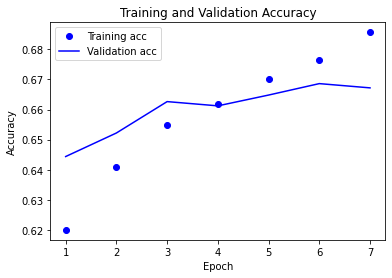

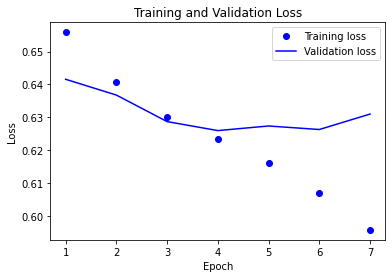

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
model.save('FinalModel.h5')

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


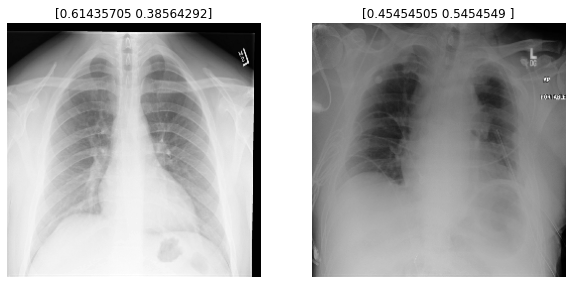

In [21]:
def show_batch_predictions(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(2):
        ax = plt.subplot(1, 2, n + 1)
        image =tf.reshape(image_batch[n],[IMG_SIZE,IMG_SIZE])
        plt.imshow(image / 255.0,cmap='gray')
        img_array = tf.expand_dims(image_batch[n], axis=0)
        plt.title(model.predict(img_array)[0])
        plt.axis("off")


image_batch, label_batch = next(iter(train_dataset))

show_batch_predictions(image_batch)